<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day24_Personal_Book_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept:** Content-based Filtering

Content-based filtering is a recommendation technique that uses item features (in this case, book characteristics like genre, author style, themes, etc.) to find similarities between items and make recommendations based on these similarities rather than user behavior.

**A system that suggests books similar to ones you like, based on what the books are about (not based on what other users liked).**

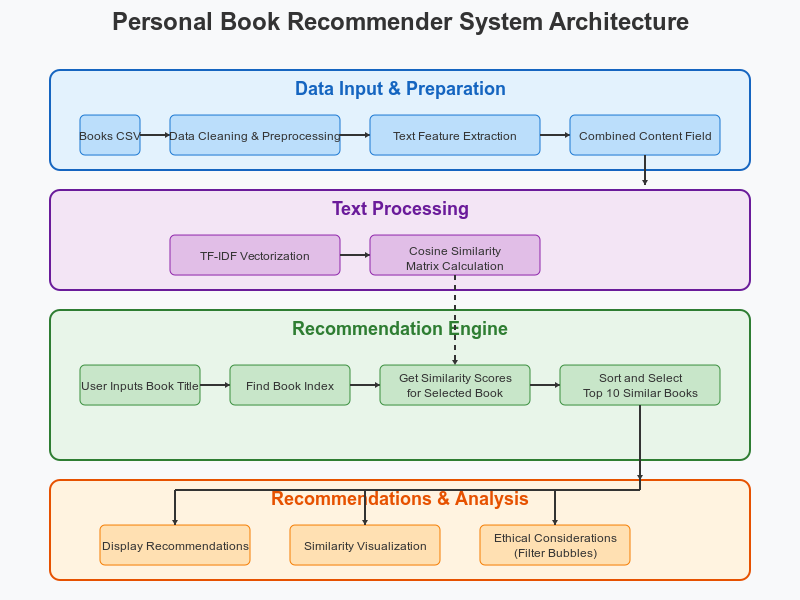

**Set Up Your Environment**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re

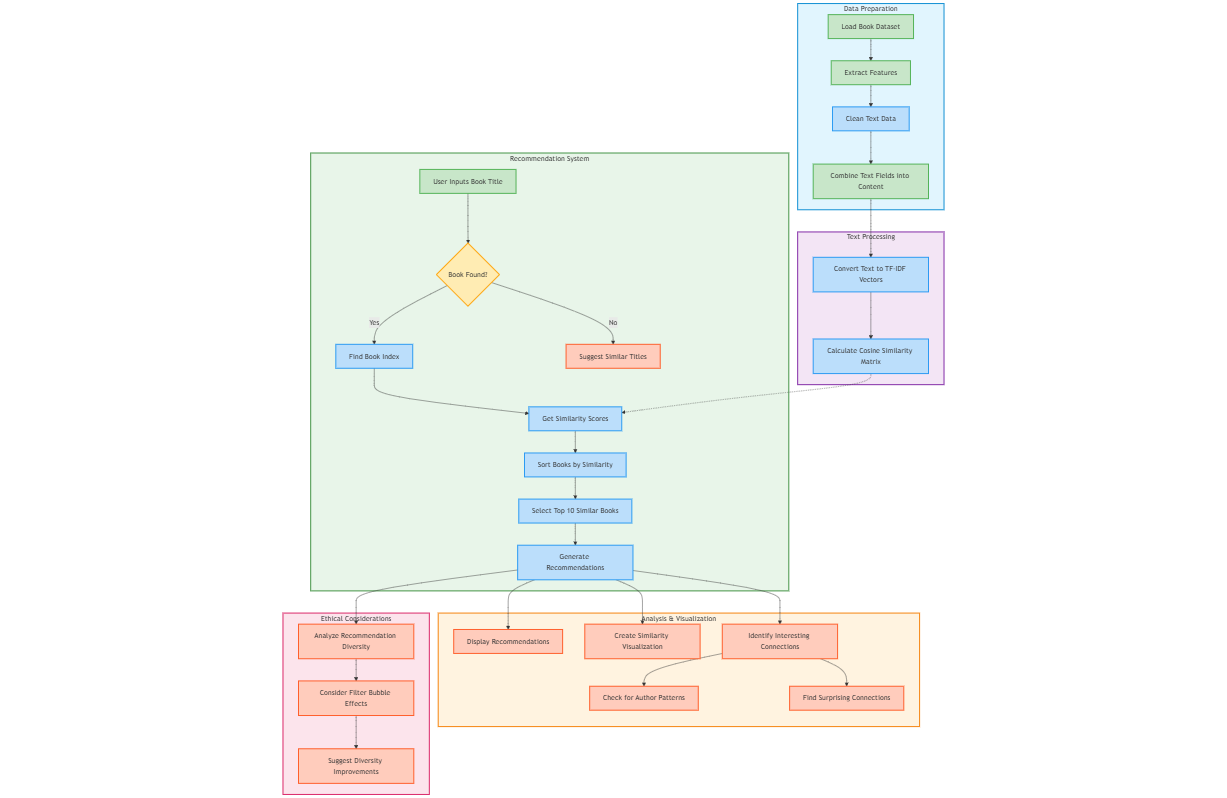

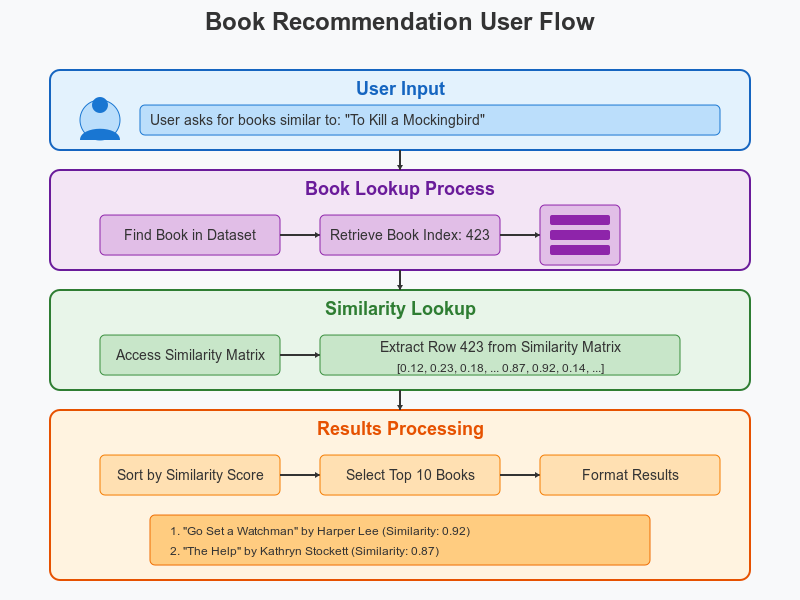

**Get and Load the Dataset**

In [2]:
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
books_df = pd.read_csv(url)

# Let's look at the first few rows to understand the data
print("Dataset shape:", books_df.shape)
books_df.head()

Dataset shape: (10000, 23)


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


**Explore and Prepare the Data**

In [3]:
# Check the column names
print("Columns in the dataset:", books_df.columns.tolist())

# Check for missing values
print("\nMissing values in each column:")
print(books_df.isnull().sum())

# Let's focus on the columns we need
# We'll primarily use the title, authors, and description for our content-based recommender
# If the dataset doesn't have descriptions, we might use other text fields

# Let's create a combined text field for analysis
# This will combine various text fields to create a rich representation of each book
books_df['content'] = books_df['title'] + ' ' + books_df['authors'].fillna('')

# If there are book tags or genres in the dataset, add those too
if 'genres' in books_df.columns:
    books_df['content'] = books_df['content'] + ' ' + books_df['genres'].fillna('')

# If there are descriptions, add those as well
if 'description' in books_df.columns:
    books_df['content'] = books_df['content'] + ' ' + books_df['description'].fillna('')

# Clean the text (lowercase, remove special characters)
books_df['content'] = books_df['content'].str.lower()
books_df['content'] = books_df['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

# Display a sample of the content field
print("\nSample content field:")
print(books_df['content'].iloc[0][:200] + "...")  # Show first 200 characters of the first book

Columns in the dataset: ['book_id', 'goodreads_book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']

Missing values in each column:
book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_

**Convert Text to TF-IDF Vectors**

In [4]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Generate TF-IDF vectors for the content
tfidf_matrix = tfidf.fit_transform(books_df['content'])

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("This means we have {} books represented by {} features".format(tfidf_matrix.shape[0], tfidf_matrix.shape[1]))

TF-IDF matrix shape: (10000, 5000)
This means we have 10000 books represented by 5000 features


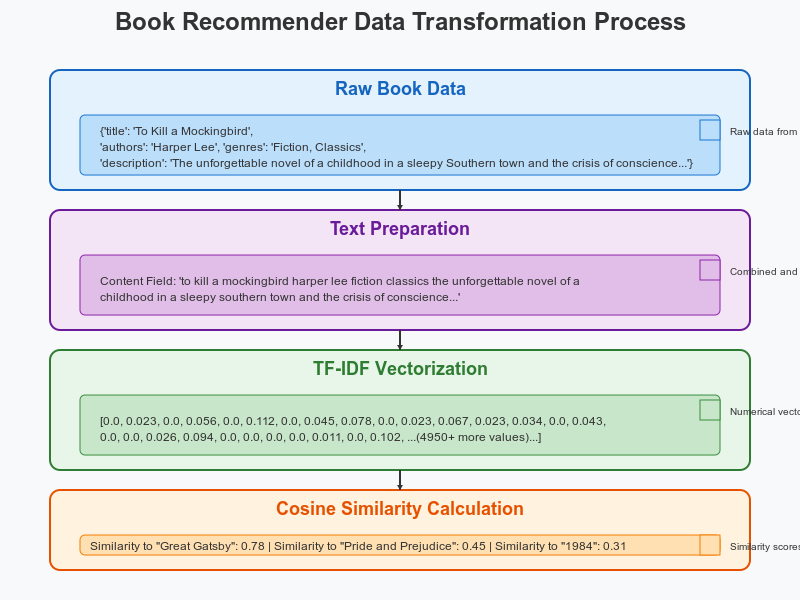

**Calculate Book Similarities**

In [5]:
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Print the shape of the similarity matrix
print("Similarity matrix shape:", cosine_sim.shape)

# Look at a small section of the similarity matrix
print("\nSample similarities (first 5x5 section):")
print(cosine_sim[:5, :5])

Similarity matrix shape: (10000, 10000)

Sample similarities (first 5x5 section):
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


**Build the Recommendation Function**

In [6]:
# Create a mapping of book titles to indices
indices = pd.Series(books_df.index, index=books_df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    """
    Get book recommendations based on content similarity

    Parameters:
    -----------
    title : str
        The title of the book for which recommendations are needed
    cosine_sim : numpy.ndarray
        The cosine similarity matrix

    Returns:
    --------
    pandas.DataFrame
        Top 10 similar books with titles and similarity scores
    """
    try:
        # Get the index of the book that matches the title
        idx = indices[title]

        # Get the similarity scores of all books with that book
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the books based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 11 most similar books (first one is the book itself)
        sim_scores = sim_scores[1:11]

        # Get the book indices
        book_indices = [i[0] for i in sim_scores]

        # Create a DataFrame with recommended books and their similarity scores
        recommendations = pd.DataFrame({
            'title': books_df['title'].iloc[book_indices].values,
            'authors': books_df['authors'].iloc[book_indices].values,
            'similarity_score': [i[1] for i in sim_scores]
        })

        return recommendations

    except KeyError:
        similar_titles = books_df[books_df['title'].str.contains(title, case=False)]
        if not similar_titles.empty:
            print(f"Book title '{title}' not found. Did you mean one of these?")
            return similar_titles[['title', 'authors']].head(5)
        else:
            print(f"Book title '{title}' not found. Please check the spelling or try another title.")
            return pd.DataFrame()

**Test the Recommender System**

In [7]:
# Get a random book title for testing
random_book = books_df['title'].sample().iloc[0]
print(f"Getting recommendations for: '{random_book}' by {books_df[books_df['title'] == random_book]['authors'].iloc[0]}")

# Get recommendations
recommendations = get_recommendations(random_book)

# Display recommendations
print("\nTop 10 Book Recommendations:")
recommendations

Getting recommendations for: 'Roller Girl' by Victoria Jamieson

Top 10 Book Recommendations:


,title,authors,similarity_score
0,Pinkalicious,"Victoria Kann, Elizabeth Kann",0.622599
1,The Island,Victoria Hislop,0.582433
2,"The Archived (The Archived, #1)",Victoria Schwab,0.526108
3,Selected Stories,"O. Henry, Victoria Blake",0.394543
4,"Evelyn, After",Victoria Helen Stone,0.392393
5,Color: A Natural History of the Palette,Victoria Finlay,0.391697
6,Giada's Family Dinners,"Giada De Laurentiis, Victoria Pearson",0.382695
7,Girl in Translation,Jean Kwok,0.377669
8,"The It Girl (It Girl, #1)",Cecily von Ziegesar,0.377262
9,Lab Girl,Hope Jahren,0.376421


**Find Interesting Connections and Visualize**

Some popular books in the dataset:


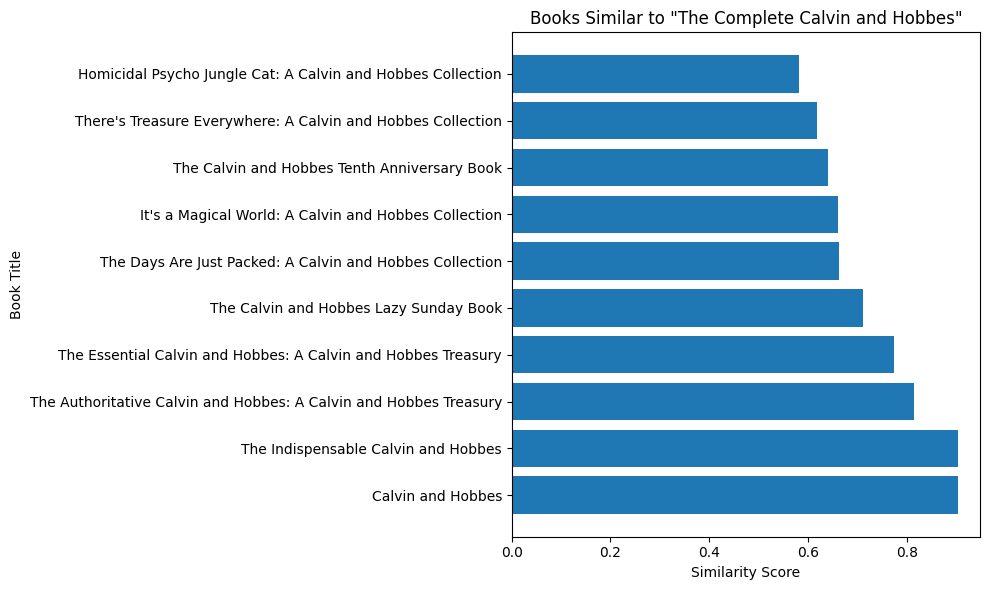


Interesting connections in the recommendations:
- Calvin and Hobbes by Bill Watterson, G.B. Trudeau (Similarity: 0.90)
- The Indispensable Calvin and Hobbes by Bill Watterson (Similarity: 0.90)
- The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury by Bill Watterson (Similarity: 0.81)
- The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury by Bill Watterson (Similarity: 0.77)
- The Calvin and Hobbes Lazy Sunday Book by Bill Watterson (Similarity: 0.71)
- The Days Are Just Packed: A Calvin and Hobbes Collection by Bill Watterson (Similarity: 0.66)
- It's a Magical World: A Calvin and Hobbes Collection by Bill Watterson (Similarity: 0.66)
- The Calvin and Hobbes Tenth Anniversary Book by Bill Watterson (Similarity: 0.64)
- There's Treasure Everywhere: A Calvin and Hobbes Collection by Bill Watterson (Similarity: 0.62)
- Homicidal Psycho Jungle Cat: A Calvin and Hobbes Collection by Bill Watterson (Similarity: 0.58)


In [8]:
# Let's find some popular books to test
popular_books = books_df.sort_values('average_rating', ascending=False).head(10)
print("Some popular books in the dataset:")
popular_books[['title', 'authors', 'average_rating']].head(5)

# Choose one of these popular books
test_book = popular_books['title'].iloc[0]
test_recommendations = get_recommendations(test_book)

# Visualize the similarity scores
plt.figure(figsize=(10, 6))
plt.barh(test_recommendations['title'], test_recommendations['similarity_score'])
plt.xlabel('Similarity Score')
plt.ylabel('Book Title')
plt.title(f'Books Similar to "{test_book}"')
plt.tight_layout()
plt.show()

# Let's analyze if there are any surprising connections
# For example, books that are similar but from different genres or time periods
print("\nInteresting connections in the recommendations:")
for i, row in test_recommendations.iterrows():
    print(f"- {row['title']} by {row['authors']} (Similarity: {row['similarity_score']:.2f})")

**Reflect on Ethical Considerations**

In [9]:
# This is a simple demonstration of potential bias in recommendations
# Let's see if our recommendations tend to favor certain authors

# Count author occurrences in recommendations
author_counts = {}

# Test with a few different books
test_books = books_df['title'].sample(5).tolist()

for book in test_books:
    recs = get_recommendations(book)
    for author in recs['authors']:
        if author in author_counts:
            author_counts[author] += 1
        else:
            author_counts[author] = 1

# Display most recommended authors
author_series = pd.Series(author_counts).sort_values(ascending=False)
print("\nMost frequently recommended authors:")
print(author_series.head(5))

print("\nEthical Consideration:")
print("Our book recommender might create 'filter bubbles' by repeatedly suggesting books by the same authors.")
print("This could limit readers' exposure to diverse perspectives and new voices in literature.")
print("To mitigate this, we could incorporate diversity measures in our recommendation algorithm.")


Most frequently recommended authors:
David Baldacci    8
Nancy Thayer      2
Craig Thompson    2
Annie Proulx      2
Gail Tsukiyama    2
dtype: int64

Ethical Consideration:
Our book recommender might create 'filter bubbles' by repeatedly suggesting books by the same authors.
This could limit readers' exposure to diverse perspectives and new voices in literature.
To mitigate this, we could incorporate diversity measures in our recommendation algorithm.


**Complete Working Illustration**

Finding a popular book for demonstration...

                  📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚                   

📖 SELECTED BOOK:
Title: The Complete Calvin and Hobbes
Author: Bill Watterson
Rating: 4.82/5.0


🔍 TOP RECOMMENDATIONS BASED ON CONTENT SIMILARITY:
--------------------------------------------------------------------------------
TITLE                                    AUTHOR                         SIMILARITY
--------------------------------------------------------------------------------
1. Calvin and Hobbes                      Bill Watterson, G.B. Trudeau   0.90
2. The Indispensable Calvin and Hobbes    Bill Watterson                 0.90
3. The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury Bill Watterson                 0.81
4. The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury Bill Watterson                 0.77
5. The Calvin and Hobbes Lazy Sunday Book Bill Watterson                 0.71
6. The Days Are Just Packed: A Calvin an

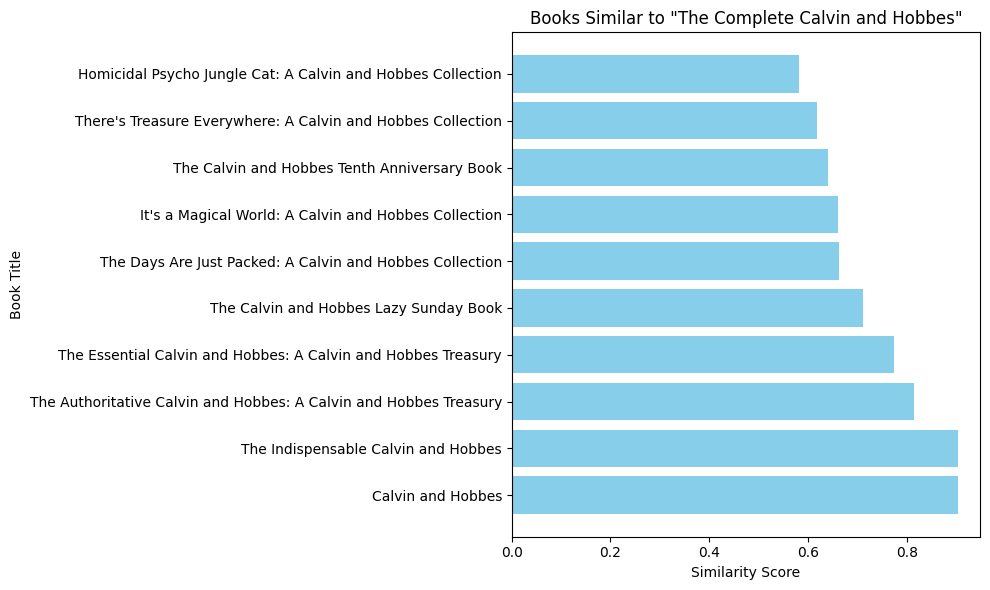


📊 RECOMMENDATION ANALYSIS:
• Found 10 books similar to "The Complete Calvin and Hobbes"
• 9 recommendations are by the same author (Bill Watterson)
• Most similar book: "Calvin and Hobbes" by Bill Watterson, G.B. Trudeau (score: 0.90)
• Most surprising connection: "Homicidal Psycho Jungle Cat: A Calvin and Hobbes Collection" by Bill Watterson (score: 0.58)

⚖️ ETHICAL REFLECTION:
This recommender system is based purely on content similarity, which may
create a 'filter bubble' by suggesting books very similar to what you've already read.
For a more diverse reading experience, consider occasionally selecting books
that are less similar or from genres and authors you haven't explored before.

                        🔄 INTERACTIVE BOOK RECOMMENDER 🔄                        

To use this recommender with your own book choice, use:
demonstrate_book_recommender('Your Book Title Here')

Or see random book options with:
demonstrate_book_recommender()


In [10]:

def demonstrate_book_recommender(book_title=None, show_random_options=True):
    """
    Demonstrate the complete book recommendation system with detailed output

    Parameters:
    -----------
    book_title : str, optional
        Specific book title to get recommendations for
    show_random_options : bool, optional
        Whether to show random book suggestions if no title is provided

    Returns:
    --------
    None
        Prints formatted output with book recommendations
    """
    print("\n" + "="*80)
    print("📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚".center(80))
    print("="*80 + "\n")

    if book_title is None and show_random_options:
        # Show some popular options if no book is specified
        print("Please select a book to get recommendations for. Here are some options:")
        sample_books = books_df.sample(5)['title'].tolist()
        for i, book in enumerate(sample_books, 1):
            author = books_df[books_df['title'] == book]['authors'].iloc[0]
            print(f"{i}. \"{book}\" by {author}")
        return

    # Get information about the selected book
    try:
        book_info = books_df[books_df['title'] == book_title].iloc[0]

        # Display information about the selected book
        print("📖 SELECTED BOOK:")
        print(f"Title: {book_info['title']}")
        print(f"Author: {book_info['authors']}")
        if 'average_rating' in book_info:
            print(f"Rating: {book_info['average_rating']}/5.0")
        if 'publication_year' in book_info:
            print(f"Published: {book_info['publication_year']}")
        if 'genres' in book_info:
            print(f"Genres: {book_info['genres']}")
        print("\n")

        # Get recommendations
        recommendations = get_recommendations(book_title)

        # Display recommendations in a nice format
        print("🔍 TOP RECOMMENDATIONS BASED ON CONTENT SIMILARITY:")
        print("-"*80)
        print(f"{'TITLE':<40} {'AUTHOR':<30} {'SIMILARITY':<10}")
        print("-"*80)

        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']:<38} {row['authors']:<30} {row['similarity_score']:.2f}")

        # Visualize the recommendations
        plt.figure(figsize=(10, 6))
        plt.barh(recommendations['title'], recommendations['similarity_score'], color='skyblue')
        plt.xlabel('Similarity Score')
        plt.ylabel('Book Title')
        plt.title(f'Books Similar to "{book_title}"')
        plt.tight_layout()
        plt.show()

        # Add an insightful analysis
        print("\n📊 RECOMMENDATION ANALYSIS:")
        print(f"• Found {len(recommendations)} books similar to \"{book_title}\"")

        # Check for author similarity
        same_author = recommendations[recommendations['authors'] == book_info['authors']]
        if not same_author.empty:
            print(f"• {len(same_author)} recommendations are by the same author ({book_info['authors']})")

        # Look for surprising connections
        if len(recommendations) > 0:
            most_similar = recommendations.iloc[0]
            least_similar = recommendations.iloc[-1]
            print(f"• Most similar book: \"{most_similar['title']}\" by {most_similar['authors']} (score: {most_similar['similarity_score']:.2f})")
            print(f"• Most surprising connection: \"{least_similar['title']}\" by {least_similar['authors']} (score: {least_similar['similarity_score']:.2f})")

        # Ethical consideration
        print("\n⚖️ ETHICAL REFLECTION:")
        print("This recommender system is based purely on content similarity, which may")
        print("create a 'filter bubble' by suggesting books very similar to what you've already read.")
        print("For a more diverse reading experience, consider occasionally selecting books")
        print("that are less similar or from genres and authors you haven't explored before.")

    except (KeyError, IndexError):
        print(f"⚠️ Book title '{book_title}' not found. Please check the spelling or try another title.")
        similar_titles = books_df[books_df['title'].str.contains(book_title, case=False)]
        if not similar_titles.empty:
            print("\nDid you mean one of these?")
            for i, (_, row) in enumerate(similar_titles.head(5).iterrows(), 1):
                print(f"{i}. \"{row['title']}\" by {row['authors']}")

# Now, let's demonstrate with a popular book
print("Finding a popular book for demonstration...")
popular_book = books_df.sort_values('average_rating', ascending=False).iloc[0]['title']

# Run the full demonstration
demonstrate_book_recommender(popular_book)

# Also provide an interactive option
print("\n" + "="*80)
print("🔄 INTERACTIVE BOOK RECOMMENDER 🔄".center(80))
print("="*80)
print("\nTo use this recommender with your own book choice, use:")
print("demonstrate_book_recommender('Your Book Title Here')")
print("\nOr see random book options with:")
print("demonstrate_book_recommender()")

**Test 1**


                  📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚                   

📖 SELECTED BOOK:
Title: I Will Teach You To Be Rich
Author: Ramit Sethi
Rating: 4.04/5.0


🔍 TOP RECOMMENDATIONS BASED ON CONTENT SIMILARITY:
--------------------------------------------------------------------------------
TITLE                                    AUTHOR                         SIMILARITY
--------------------------------------------------------------------------------
1. China Rich Girlfriend (Crazy Rich Asians #2) Kevin Kwan                     0.64
2. Rich Dad's Guide to Investing: What the Rich Invest in That the Poor and Middle Class Do Not! Robert T. Kiyosaki, Sharon L. Lechter 0.55
3. Crazy Rich Asians (Crazy Rich Asians #1) Kevin Kwan                     0.51
4. Think and Grow Rich: The Landmark Bestseller - Now Revised and Updated for the 21st Century Napoleon Hill                  0.50
5. Rich Dad's Cashflow Quadrant: Rich Dad's Guide to Financial Freedom Robert T. Kiyosaki, Shar

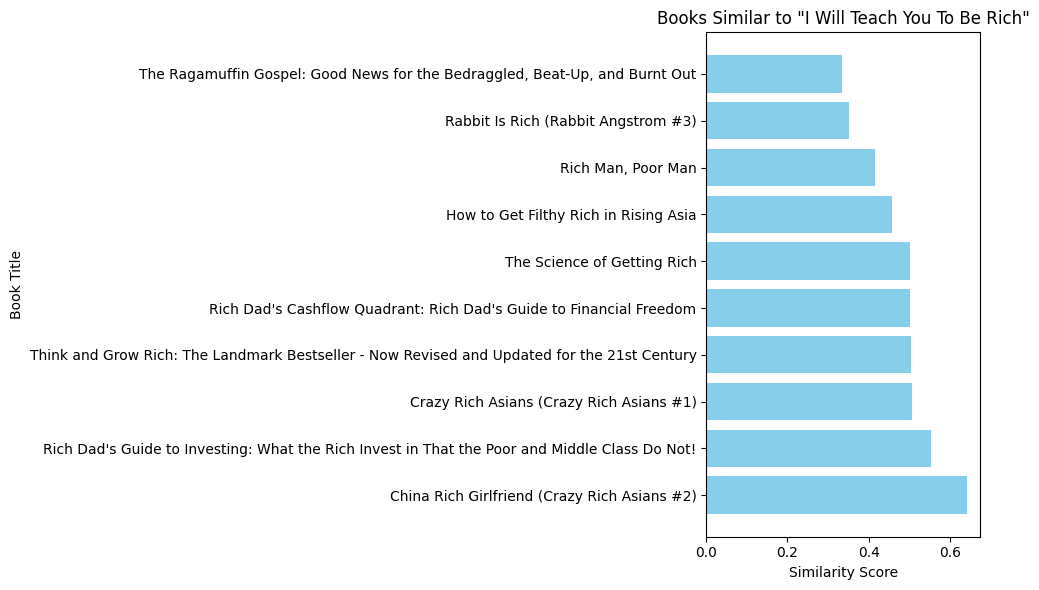


📊 RECOMMENDATION ANALYSIS:
• Found 10 books similar to "I Will Teach You To Be Rich"
• Most similar book: "China Rich Girlfriend (Crazy Rich Asians #2)" by Kevin Kwan (score: 0.64)
• Most surprising connection: "The Ragamuffin Gospel: Good News for the Bedraggled, Beat-Up, and Burnt Out" by Brennan Manning, Michael W. Smith, Rich Mullins (score: 0.33)

⚖️ ETHICAL REFLECTION:
This recommender system is based purely on content similarity, which may
create a 'filter bubble' by suggesting books very similar to what you've already read.
For a more diverse reading experience, consider occasionally selecting books
that are less similar or from genres and authors you haven't explored before.

                  📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚                   

Please select a book to get recommendations for. Here are some options:
1. "A Man Without a Country" by Kurt Vonnegut Jr.
2. "And Another Thing..." by Eoin Colfer
3. "Year of Yes: How to Dance It Out, Stand In the Sun and B

In [24]:
#To use this recommender with your own book choice, use:
demonstrate_book_recommender('I Will Teach You To Be Rich')

# see random book options with:
demonstrate_book_recommender()

**Test2**


                  📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚                   

📖 SELECTED BOOK:
Title: To Kill a Mockingbird
Author: Harper Lee
Rating: 4.25/5.0


🔍 TOP RECOMMENDATIONS BASED ON CONTENT SIMILARITY:
--------------------------------------------------------------------------------
TITLE                                    AUTHOR                         SIMILARITY
--------------------------------------------------------------------------------
1. Go Set a Watchman                      Harper Lee                     0.50
2. Mockingbird                            Kathryn Erskine                0.37
3. A Time to Kill                         John Grisham                   0.29
4. The Last Boleyn                        Karen Harper                   0.28
5. Dragonsong (Harper Hall, #1)           Anne McCaffrey                 0.26
6. Dragonsinger (Harper Hall, #2)         Anne McCaffrey                 0.26
7. Dragondrums (Harper Hall, #3)          Anne McCaffrey             

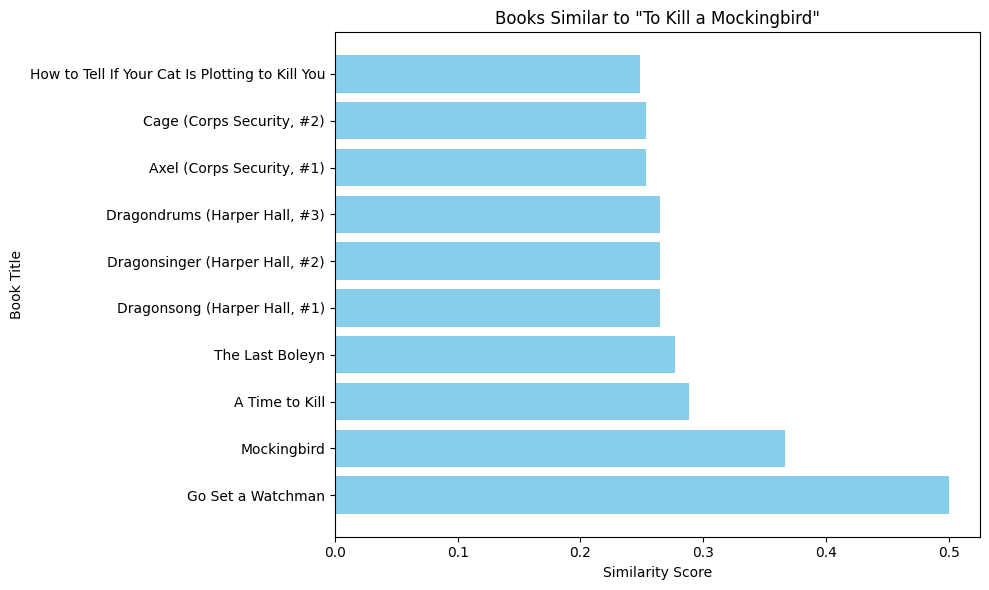


📊 RECOMMENDATION ANALYSIS:
• Found 10 books similar to "To Kill a Mockingbird"
• 1 recommendations are by the same author (Harper Lee)
• Most similar book: "Go Set a Watchman" by Harper Lee (score: 0.50)
• Most surprising connection: "How to Tell If Your Cat Is Plotting to Kill You" by Matthew Inman, The Oatmeal (score: 0.25)

⚖️ ETHICAL REFLECTION:
This recommender system is based purely on content similarity, which may
create a 'filter bubble' by suggesting books very similar to what you've already read.
For a more diverse reading experience, consider occasionally selecting books
that are less similar or from genres and authors you haven't explored before.

                  📚 PERSONAL BOOK RECOMMENDER DEMONSTRATION 📚                   

Please select a book to get recommendations for. Here are some options:
1. "Step on a Crack (Michael Bennett, #1)" by James Patterson, Michael Ledwidge
2. "Calling Me Home" by Julie Kibler
3. "The Bazaar of Bad Dreams" by Stephen King
4. "Gateway (H

In [30]:
#To use this recommender with your own book choice, use:
demonstrate_book_recommender('To Kill a Mockingbird')

# see random book options with:
demonstrate_book_recommender()